In [1]:
import math
import random
import sys
import torch
import torch.nn as nn
from collections import defaultdict

In [2]:
!pip install pytorch-lightning

In [54]:
test_time = 100

In [137]:
class VanillaOU(nn.Module):
    def __init__(self, mean_rev_speed, mean_rev_level, vola, num_seq=1, mode='train', device='cpu'):
        '''
        Args:
            mean_rev_speed:
            
        '''
        super(VanillaOU, self).__init__()
        if mode == 'train': # TODO: for now it only considers parameters to optimize
            speed = torch.rand((1,), device=device)
            self.mean_rev_speed = nn.Parameter(speed, requires_grad=True)
            
            level = torch.rand((1,), device=device)
            self.mean_rev_level = nn.Parameter(level, requires_grad=True)
            # vola = torch.rand((1,), device=device)
            # self.vola = torch.relu(nn.Parameter(vola, requires_grad=True))
            vola = torch.tensor((0.01), device=device)
            self.vola = torch.relu(nn.Parameter(vola, requires_grad=False))
        elif mode == 'synthetic':
            self.mean_rev_speed = mean_rev_speed
            self.mean_rev_level = mean_rev_level
            self.vola = vola
        else:
            raise Exception('It is not a compatible mode')
            
        self.num_seq = num_seq
        assert self.mean_rev_speed >= 0
        assert self.vola >= 0
        

    def variance(self, t):
        return self.vola * self.vola * (1.0 - torch.exp(- 2.0 * self.mean_rev_speed * t)) / (2 * self.mean_rev_speed)

    def std(self, t):
        return torch.sqrt(self.variance(t))

    def mean(self, x0, t, mean_speed=None, mean_level=None):
        speed = mean_speed if mean_speed is not None else self.mean_rev_speed
        level = mean_level if mean_level is not None else self.mean_rev_level
        return x0 * torch.exp(-speed * t) + (1.0 - torch.exp(- speed * t)) * level

    def simulate_path(self, x0, t, items=None):
        """ 
        Simulates a sample path
        dX = A(alpha-X)dt + v dB
        """
        assert len(t) > 0
        num_seq, time_step = t.shape
        num_node = len(x0)

        dt = torch.diff(t).reshape(num_seq, -1, 1, 1)
        dt = torch.tile(dt, (1,1,num_node,1))
        dt = torch.log(dt) # TODO

        # x = torch.zeros((self.num_seq, time_step, num_node, 1), device=device)
        # x[:, 0] += x0

        noise = torch.randn(size=(self.num_seq, time_step, num_node, 1), device=device) 
        scale = self.std(dt) # [bs, t-1, num_node, 1]
        # x[:, 1:] += noise[:, 1:] * scale
        x_last = x0
        
        x_pred = []
        for i in range(1, time_step):
            # x[:, i] = self.mean(x[:, i-1], dt[:, i-1])
            x_next = self.mean(x_last, dt[:, i-1]) + noise[:, i-1]
            x_last = x_next
            x_pred.append(x_next)
        return torch.stack(x_pred, 1)#, self.mean_rev_speed, self.mean_rev_level

In [138]:
num_seq = 1
num_node = 1
speed = torch.tensor(1.67261056e-05, device=device)
mean = torch.tensor(0.63, device=device)
noise = torch.tensor(0.0001, device=device)

x0 = torch.zeros((num_node, 1), device=device)
# time = torch.arange(100).to(device).reshape(1,-1)
time=torch.tensor(t_data).to(device).reshape(1,-1)

In [139]:
model = VanillaOU(speed, mean, noise, mode='synthetic')
x = model.simulate_path(x0, t=time)

In [152]:
path = x[0,:,0,0].numpy()
path.shape

(100,)

In [162]:
times=time[0].numpy()
times_rescale = np.log(np.diff(times))
scale = []
start = times_rescale[0]
scale.append(start)
for i in range(1, len(times_rescale)):
    scale.append(scale[-1]+times_rescale[i])

<Figure size 640x480 with 0 Axes>

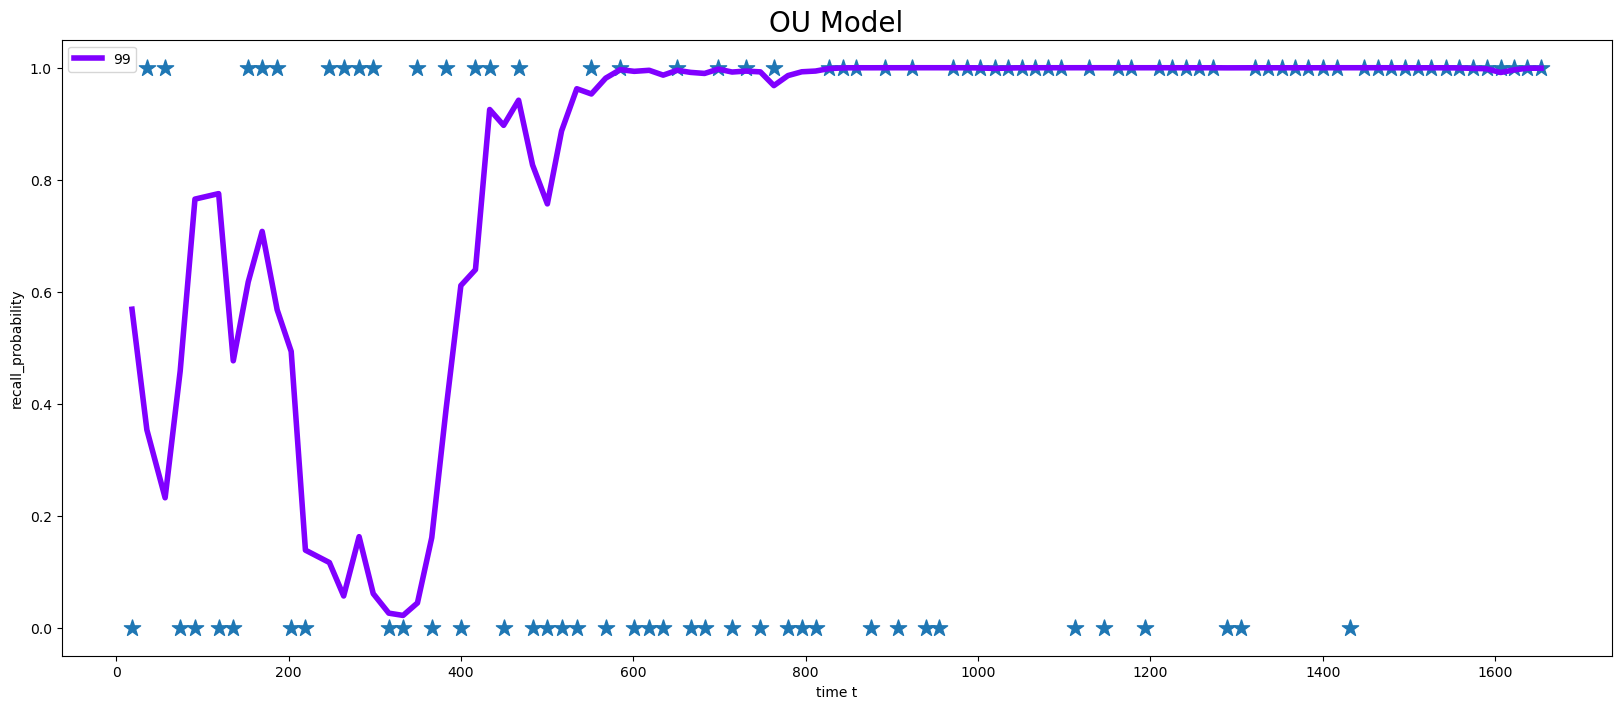

In [164]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
import networkx as nx
import os
import imageio
import ipdb

def sigmoid(x):
  return 1 / (1 + np.exp(-x))

path = x[0,:,0,0].numpy()
times=time[0].numpy()

plt.clf()

color = cm.rainbow(np.linspace(0, 1, num_node))
plt.figure(figsize=(20,8))
plt.xlabel('time t')
plt.ylabel('recall_probability')
plt.title(label='OU Model',
        fontsize=20,
        color="black")

plt.plot(scale, sigmoid(path), color=c, label='{}'.format(i), linewidth=4)

plt.scatter(scale, x_data[1:], s=150, marker='*')
    # plt.vlines(x=times[ind], ymin = np.min(path), ymax = np.max(path),
            # colors = 'grey', linestyles='dashdot')# ,
            # label = 'vline_multiple - full height')


plt.legend()

In [111]:
data = log.loc[(log.user_id == 66633) & (log.exercise == 'number_properties_terminology_1')]
data = data.sort_values('time_done')

In [112]:
t_data = np.array(data['time_done'].values) # .reshape(1, -1)
x_data = np.array(data['correct'].values*1) # .reshape(1, -1)*1

In [113]:
t_data.shape

(101,)

In [82]:
t = tensor_data[0]
x0 =tensor_data[1][:, 0:1]

mean_rev_speed = torch.tensor(0.1, device=device)
mean_rev_level = torch.tensor(0.5, device=device)
vola = torch.tensor(0.01, device=device)

def variance(t):
    return vola * vola * (1.0 - torch.exp(- 2.0 * mean_rev_speed * t)) / (2 * mean_rev_speed)

def std(t):
    return torch.sqrt(variance(t))

def mean(x0, t, mean_speed=None, mean_level=None):
    speed = mean_rev_speed
    level = mean_rev_level
    return x0 * torch.exp(-speed * t) + (1.0 - torch.exp(- speed * t)) * level


In [109]:
# Test Block
loss_fn = torch.nn.BCELoss()
learning_rate = 1e-2
model = VanillaOU(speed, mean, noise, mode='train',device=device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

torch.autograd.set_detect_anomaly(True)
for t in range(100):
    # Forward pass: compute predicted y by passing x to the model. Module objects
    # override the __call__ operator so you can call them like functions. When
    # doing so you pass a Tensor of input data to the Module and it produces
    # a Tensor of output data.
    y_pred, speed, level = model.simulate_path(x0=tensor_data[1][:, 0:1], t = tensor_data[0])
    y_pred = torch.sigmoid(y_pred)
    
    loss = loss_fn(y_pred[:,:,0,0], tensor_data[1][:,1:test_time].float())
    # if t % 100 == 0:
    print(t, loss.item())
    print('prediction: ', y_pred[:, -10:,0,0])
    print('label: ', tensor_data[1][:,test_time-10:test_time])
    print('speed: ', speed.clone(), speed.grad)
    print('level: ', level.clone(), level.grad)

    optimizer.zero_grad()
    loss.backward(retain_graph = True)
    optimizer.step()
    for p in model.parameters():
        p.data.clamp_(0)
    # print('After: ', list(hlr.parameters())[0].clone(), hlr.theta.grad)

TypeError: cannot assign 'torch.FloatTensor' as parameter 'mean_rev_speed' (torch.nn.Parameter or None expected)

In [92]:
num_seq, time_step = t.shape
num_node = len(x0)

dt = torch.diff(t).reshape(num_seq, -1, 1, 1)
dt = torch.tile(dt, (1,1,num_node,1))
dt = torch.log(dt)

# x = torch.zeros((self.num_seq, time_step, num_node, 1), device=device)
# x[:, 0] += x0

noise = torch.randn(size=(num_seq, time_step, num_node, 1), device=device) 
scale = std(dt) # [bs, t-1, num_node, 1]
# x[:, 1:] += noise[:, 1:] * scale
x_last = x0

x_pred = []
for i in range(1, test_time):
    # x[:, i] = self.mean(x[:, i-1], dt[:, i-1])
    x_next = mean(x_last, dt[:, i-1]) + noise[:, i-1]
    x_last = x_next
    x_pred.append(x_next)

In [8]:
device

'cpu'

# Data

In [4]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
from collections import defaultdict
import operator

bath_path = '/mnt/qb/work/mlcolab/hzhou52/kt/junyi/'

# exercise 837, topic 41, area 9
exercise = pd.read_csv(bath_path+'junyi_Exercise_table.csv', encoding = "utf-8",low_memory=False) 
relation = pd.read_csv(bath_path+'relationship_annotation_training.csv', encoding = "utf-8",low_memory=False)
log = pd.read_csv(bath_path+'junyi_ProblemLog_original.csv', encoding = "utf-8",low_memory=False)

# log.head()
users = log.groupby(['user_id', 'exercise']).size().reset_index(name='count')
users = users.sort_values('count')

In [5]:
first = log.loc[(log.user_id == 88703) & (log.exercise == 'telling_time_comparing')]
second = log.loc[(log.user_id == 88703) & (log.exercise == 'time_units_transformation_1')]
third = log.loc[(log.user_id == 52504) & (log.exercise == 'radical_equations')]

In [6]:
first = first.sort_values('time_done')

In [7]:
import os
from torch import optim, nn, utils, Tensor
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import pytorch_lightning as pl

# Training arguments
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
batch_size = 32
epoch = 200
num_seq = 1

# add statistics
times = first.time_done.values.reshape(num_seq, -1)
corrects = first.correct.values.reshape(num_seq, -1)
num_total = np.arange(times.shape[-1])
success = 0
num_success = []
for i in range(times.shape[-1]):
    if corrects[:, i] == 1:
        success += 1
    num_success.append(success)
num_failure = num_total-num_success

stats = np.stack([num_total, num_success, num_failure], -1).reshape(num_seq, -1, 3)

# setup tensor data
data = [times, corrects, stats]
tensor_data = [torch.tensor(t*1, device=device) for t in data]

# tensor_data:
## times: [num_seq, t]
## labels: [num_seq, t]
## stats: [num_seq, t, 3]

train_loader = utils.data.DataLoader(tensor_data, batch_size=batch_size, shuffle=False)

# HLR model

In [595]:
MIN_HALF_LIFE = torch.tensor(15.0 / (24 * 60), device=device)    # 15 minutes
MAX_HALF_LIFE = torch.tensor(274., device=device)                # 9 months
MIN_P = torch.tensor(0.0001, device=device)
MAX_P = torch.tensor(0.9999, device=device)
LN2 = torch.tensor(math.log(2.), device=device)
test_epoch = 5

def hclip(h):
    # bound min/max half-life
    return torch.min(torch.max(h, MIN_HALF_LIFE), MAX_HALF_LIFE)
def pclip(p):
    # bound min/max model predictions (helps with loss optimization)
    return torch.min(torch.max(p, MIN_P), MAX_P)


class HLR(nn.Module):
    def __init__(self, theta=None, base=2, num_seq=1, mode='train', device='cpu'):
        '''
        Args:
            theta: [3, ]; should be 3D vector indicates the parameters of the model; 
                the näive version is to compute the dot product of theta and [N_total, N_success, N_failure]
            base: the base of HLR model
            num_seq: when mode==synthetic, it is the number of sequences to generate;
                is mode==train, it is the number of batch size
            mode: [synthetic, train]; synthetic is to generate new sequences based on given theta; train is to 
                train the parameters theta given observed data.
            device: cpu or cuda to put all variables and train the model
        '''
        super().__init__()
        if mode == 'train':
            theta = torch.empty(1,3, device=device)
            theta = torch.nn.init.xavier_uniform_(theta)[0]
            self.theta = nn.Parameter(theta, requires_grad=True).to(device)
        elif mode == 'synthetic':
            self.theta = torch.tensor(theta, device=device)
        else:
            raise Exception('It is not a compatible mode')
        self.num_seq = num_seq
        self.base = base
        self.device = device

    def simulate_path(self, x0, t, items=None, stats_cal_on_fly=False, stats=None):
        '''
        Args:
            x0: shape[bs, num_node]; the initial state of the learner model
            t: shape[bs, num_time_step]
            items: [bs, num_time_step]
            stats_cal_on_fly:
            stats: 
        '''
        torch.autograd.set_detect_anomaly(True) 
        num_node = x0.shape[-1]
        num_seq, time_step = t.shape

        dt = torch.diff(t).reshape(num_seq, -1)

        x = torch.zeros((num_seq, time_step, num_node, 1), device=device)
        x[:, 0] += x0

        if items == None:
            items = torch.zeros_like(t, device=device)

        if stats_cal_on_fly:
            item_start = items[:, 0]
            all_feature = torch.zeros((num_seq, num_node, 3), device=device)
            all_feature[torch.arange(0, num_seq), item_start, 0] += 1
            all_feature[torch.arange(0, num_seq), item_start, 2] += 1
        else: 
            pass
            
        all_features = []
        half_lifes = []
        for i in range(1, test_epoch):
            # if i % 5 == 0:
            #     print(i)
            cur_item = items[:, i] # [num_seq, ] 
            cur_dt = dt[:, i-1:i]

            half_life = hclip(self.base ** (all_feature.clone() @ self.theta))
            # half_life = self.base ** (all_feature.clone() @ self.theta)
            p_all = torch.sigmoid(self.base ** (-torch.log(cur_dt)/half_life)) # TODO how to give the dt the right temperature
            p_item = p_all[torch.arange(0,num_seq), cur_item]

            success = nn.functional.gumbel_softmax(torch.log(p_item), hard=True)
            all_feature[torch.arange(num_seq), cur_item, 0] += 1
            all_feature[torch.arange(num_seq), cur_item, 1] += success
            all_feature[torch.arange(num_seq), cur_item, 2] += 1-success

            tmp_feature = all_feature#.detach().clone()
            all_features.append(tmp_feature)
            half_lifes.append(torch.clone(half_life))

            x[:, i, :, 0] += p_all# .clone()

        all_features = torch.stack(all_features, 1).int() # [num_seq, time_step-1, num_node, 3]
        half_lifes = torch.stack(half_lifes, 1)
        params = {
            'half_life': half_lifes,
            'num_history': all_features[..., 0:1],
            'num_success': all_features[..., 1:2],
            'num_failure': all_features[..., 2:3],
        }
        
        
        return x, params, all_feature

In [35]:
MIN_HALF_LIFE = torch.tensor(15.0 / (24 * 60), device=device)    # 15 minutes
MAX_HALF_LIFE = torch.tensor(274., device=device)                # 9 months
MIN_P = torch.tensor(0.0001, device=device)
MAX_P = torch.tensor(0.9999, device=device)
LN2 = torch.tensor(math.log(2.), device=device)
test_epoch = 200

def hclip(h):
    # bound min/max half-life
    return torch.min(torch.max(h, MIN_HALF_LIFE), MAX_HALF_LIFE)
def pclip(p):
    # bound min/max model predictions (helps with loss optimization)
    return torch.min(torch.max(p, MIN_P), MAX_P)


class HLR(nn.Module):
    def __init__(self, theta=None, base=2, num_seq=1, mode='train', device='cpu'):
        '''
        Args:
            theta: [3, ]; should be 3D vector indicates the parameters of the model; 
                the näive version is to compute the dot product of theta and [N_total, N_success, N_failure]
            base: the base of HLR model
            num_seq: when mode==synthetic, it is the number of sequences to generate;
                is mode==train, it is the number of batch size
            mode: [synthetic, train]; synthetic is to generate new sequences based on given theta; train is to 
                train the parameters theta given observed data.
            device: cpu or cuda to put all variables and train the model
        '''
        super().__init__()
        if mode == 'train':
            theta = torch.empty(1,3, device=device)
            theta = torch.nn.init.xavier_uniform_(theta)[0]*1e-2
            self.theta = nn.Parameter(theta, requires_grad=True).to(device)
        elif mode == 'synthetic':
            self.theta = torch.tensor(theta, device=device)
        else:
            raise Exception('It is not a compatible mode')
        self.num_seq = num_seq
        self.base = base
        self.device = device

    def simulate_path(self, x0, t, items=None, stats=None):
        '''
        Args:
            x0: shape[bs, num_node]; the initial state of the learner model
            t: shape[bs, num_time_step]
            items: [bs, num_time_step]
        '''
        torch.autograd.set_detect_anomaly(True) 
        num_node = x0.shape[-1]
        num_seq, time_step = t.shape

        dt = torch.diff(t).reshape(num_seq, -1)

        x = torch.zeros((num_seq, time_step, num_node, 1), device=device)
        x[:, 0] += x0

        if items == None:
            items = torch.zeros_like(t, device=device)

        item_start = items[:, 0]
        all_feature = torch.zeros((num_seq, num_node, 3), device=device)
        all_feature[torch.arange(0, num_seq), item_start, 0] += 1
        all_feature[torch.arange(0, num_seq), item_start, 2] += 1

        all_features = []
        half_lifes = []
        
        all_features.append(all_feature)
        for i in range(1, test_epoch):
            cur_item = items[:, i] # [num_seq, ] 
            cur_dt = dt[:, i-1:i]

            half_life = hclip(self.base ** (stats[:,i] @ self.theta))
            # half_life = self.base ** (stats[:,i] @ self.theta)
            p_all = torch.sigmoid(self.base ** (-torch.log(cur_dt)/half_life)) 
            
            p_item = p_all[torch.arange(0,num_seq), cur_item]
            x[:,i,:,0] = x[:,i,:,0] + p_all # .clone()

            success = nn.functional.gumbel_softmax(torch.log(p_item), hard=True)
            tmp_feature = torch.stack([torch.ones_like(success, device=device), success, 1-success], -1).clone()
            
            h = all_feature[torch.arange(num_seq), cur_item] 
            all_feature[torch.arange(num_seq), cur_item] = (h+tmp_feature)
            
            # all_feature[torch.arange(num_seq), cur_item, 0] += 1
            # all_feature[torch.arange(num_seq), cur_item, 1] += success
            # all_feature[torch.arange(num_seq), cur_item, 2] += 1-success

            all_features.append(all_feature.clone())
            half_lifes.append(half_life.clone())

        all_features = torch.stack(all_features, 1).int() # [num_seq, time_step-1, num_node, 3]
        half_lifes = torch.stack(half_lifes, 1)
        params = {
            'half_life': half_lifes,
            'num_history': all_features[..., 0:1],
            'num_success': all_features[..., 1:2],
            'num_failure': all_features[..., 2:3],
        }
        
        
        return x, params, all_feature, success, tmp_feature, half_life, p_all

In [38]:
# Test Block
loss_fn = torch.nn.BCELoss()
learning_rate = 1e-1
hlr = HLR(device=device)
optimizer = torch.optim.SGD(hlr.parameters(), lr=learning_rate)


for t in range(5):
    # Forward pass: compute predicted y by passing x to the model. Module objects
    # override the __call__ operator so you can call them like functions. When
    # doing so you pass a Tensor of input data to the Module and it produces
    # a Tensor of output data.
    y_pred, params, all_feature, success, tmp_feature, half_life, p_all = \
        hlr.simulate_path(x0=tensor_data[1][:, 0:1], t = tensor_data[0], stats=tensor_data[2].float())

    
    loss = loss_fn(y_pred[:,:test_epoch,0,0], tensor_data[1][:,1:test_epoch+1].float())
    # if t % 100 == 0:
    print(t, loss.item())
    print('Before: ', list(hlr.parameters())[0].clone(), hlr.theta.grad)
    # print('all_feature: ', all_feature.grad)
    # print('success: ', success.grad)
    # print('tmp_feature: ', tmp_feature.grad)
    print('half_life: ', half_life)
    print('p_all: ', p_all)

    optimizer.zero_grad()
    loss.backward(retain_graph = True)
    optimizer.step()
    # print('After: ', list(hlr.parameters())[0].clone(), hlr.theta.grad)

0 0.6896810531616211
Before:  tensor([-0.0097,  0.0064,  0.0108], device='cuda:0', grad_fn=<CloneBackward0>) None
half_life:  tensor([0.8470], device='cuda:0', grad_fn=<MinimumBackward0>)
p_all:  tensor([[0.5000]], device='cuda:0', grad_fn=<SigmoidBackward0>)
1 0.6896810531616211
Before:  tensor([-0.0097,  0.0064,  0.0108], device='cuda:0', grad_fn=<CloneBackward0>) tensor([-1.0535e-04, -5.7082e-05, -4.8268e-05], device='cuda:0')
half_life:  tensor([0.8488], device='cuda:0', grad_fn=<MinimumBackward0>)
p_all:  tensor([[0.5000]], device='cuda:0', grad_fn=<SigmoidBackward0>)


KeyboardInterrupt: 

In [406]:
# define the LightningModule
torch.autograd.set_detect_anomaly(True)
class LitAutoEncoder(pl.LightningModule):
    def __init__(self, learner_model):
        super().__init__()
        self.learner_model = learner_model

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        train_time, train_label = batch
        
        y, params = self.learner_model.simulate_path(x0 = train_label[:, 0:1], t = train_time)
        loss = nn.functional.mse_loss(y[:,:,:100,0], train_label[:,1:101].float())
        # Logging to TensorBoard (if installed) by default
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer


# init the autoencoder
hlr = HLR(device=device)
autoencoder = LitAutoEncoder(hlr)

In [ ]:
# train the model (hint: here are some helpful Trainer arguments for rapid idea iteration)
torch.autograd.set_detect_anomaly(True) 
trainer = pl.Trainer(limit_train_batches=100, max_epochs=1, accelerator="gpu") 
trainer.fit(model=autoencoder, train_dataloaders=train_loader)

user_id                               exercise  count
1144894   123793                    writing_fractions_1      1
993027    107307                       rounding_numbers      1
993028    107307              same_side_interior_angles      1
993039    107307  the_fundamental_theorem_of_arithmetic      1
993043    107307          understanding_comparing_angle      1
...          ...                                    ...    ...
2009433   217320      sides_and_angles_of_simple_shapes   3035
537355     58228      sides_and_angles_of_simple_shapes   3127
486600     52504                      radical_equations   3128
819423     88703            time_units_transformation_1   3297
819421     88703                 telling_time_comparing   5174

[2289789 rows x 3 columns]

In [76]:
bath_path = '/mnt/qb/work/mlcolab/hzhou52/kt/Duolingo/learning_traces.csv'
log = pd.read_csv(bath_path, encoding = "utf-8",low_memory=False)

In [77]:
log.head()

p_recall   timestamp     delta user_id learning_language ui_language  \
0       1.0  1362076081  27649635    u:FO                de          en   
1       0.5  1362076081  27649635    u:FO                de          en   
2       1.0  1362076081  27649635    u:FO                de          en   
3       0.5  1362076081  27649635    u:FO                de          en   
4       1.0  1362076081  27649635    u:FO                de          en   

                          lexeme_id                     lexeme_string  \
0  76390c1350a8dac31186187e2fe1e178  lernt/lernen<vblex><pri><p3><sg>   
1  7dfd7086f3671685e2cf1c1da72796d7     die/die<det><def><f><sg><nom>   
2  35a54c25a2cda8127343f6a82e6f6b7d          mann/mann<n><m><sg><nom>   
3  0cf63ffe3dda158bc3dbd55682b355ae          frau/frau<n><f><sg><nom>   
4  84920990d78044db53c1b012f5bf9ab5    das/das<det><def><nt><sg><nom>   

   history_seen  history_correct  session_seen  session_correct  
0             6                4             2                2  
1             4                4             2                1  
2             5                4             1                1  
3             6                5             2                1  
4             4                4             1                1

In [78]:
users = log.groupby(['user_id', 'lexeme_id']).size().reset_index(name='count')
users.sort_values('count')

user_id                         lexeme_id  count
0         u:--N  01a14ea3963721a9d545dce1acc30f2f      1
3544992  u:hqtH  eb94d71d2ab1d501b230eee9d287fe73      1
3544993  u:hqtH  ec2421cd46a8a5886683b084aa8e2c5d      1
3544994  u:hqtH  ede6ab035e42c5f5523c73f955f036ac      1
3544995  u:hqtH  eee8e3c0843d6ace41d204202f197909      1
...         ...                               ...    ...
269756   u:bcH_  97e922f780d628eac638bea7a02bf496    278
269685   u:bcH_  827a8ecb89f9b59ac5c29b620a5d3ed6    295
269409   u:bcH_  33a7fd42f74b2d2b1110f1b0c8b6db38    316
269600   u:bcH_  6d4c572af8022cb4784ce0f8898d1905    328
269333   u:bcH_  1e1f8d730c4ba99ad2873a7608324cf6    352

[5861629 rows x 3 columns]

In [79]:
log.loc[log.user_id == 'u:bcH_']

p_recall   timestamp    delta user_id learning_language ui_language  \
193803         0.0  1362092353    61015  u:bcH_                en          es   
193804         1.0  1362092353    83142  u:bcH_                en          es   
193805         0.0  1362092353    83951  u:bcH_                en          es   
193806         0.0  1362092353    61191  u:bcH_                en          es   
193807         0.0  1362092353    83951  u:bcH_                en          es   
...            ...         ...      ...     ...               ...         ...   
12504242       1.0  1363066201  2678082  u:bcH_                en          es   
12504243       1.0  1363066201      144  u:bcH_                en          es   
12504244       0.0  1363066201      454  u:bcH_                en          es   
12504245       0.5  1363066201      144  u:bcH_                en          es   
12504246       0.0  1363066201      454  u:bcH_                en          es   

                                 lexeme_id                 lexeme_string  \
193803    55f383178cf0fdc463ef1ebf91bd288d              milk/milk<n><sg>   
193804    a5acd980d17d726d1c99e7b974d3f52d                   for/for<pr>   
193805    9eedd98a29691237d18c127468452836            music/music<n><sg>   
193806    4adf5cd40d521b02a9cc241bf3adc6bb         have/have<vblex><inf>   
193807    b830ca5fa936b0cff94fe712d6847f29    listen/listen<vblex><pres>   
...                                    ...                           ...   
12504242  6e7589c6b19e910e6f24f8313ab231b9   these/this<prn><tn><mf><pl>   
12504243  32d10b7ed0bea958c60a915710434dfe           can/can<vaux><pres>   
12504244  46a16bfbe06339264594d523fb04bf7a  restaurant/restaurant<n><sg>   
12504245  1e1f8d730c4ba99ad2873a7608324cf6           my/my<det><pos><sp>   
12504246  b974624f112084b39586380fe4aaf32a                man/man<n><sg>   

          history_seen  history_correct  session_seen  session_correct  
193803             157              116             1                0  
193804             750              481             1                1  
193805             181              110             1                0  
193806             913              583             1                0  
193807              93               58             1                0  
...                ...              ...           ...              ...  
12504242            43               33             1                1  
12504243          1166              899             1                1  
12504244           470              241             1                0  
12504245          5589             3230             2                1  
12504246           361              258             1                0  

[19194 rows x 12 columns]